# Library Import 

In [1]:
#pip install tensorFlow

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from dataclasses import dataclass

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

In [14]:
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [15]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import numpy as np
from collections import Counter

# Dataset directory

# Dataset Loading 

In [16]:
# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Resize images to 224x224 for compatibility with many models
DATA_DIR = "D:/dataset/Alzheimer's dataset/AugmentedAlzheimerDataset"  # Kaggle dataset path
NUM_CLASSES = 4 

In [17]:
# Create training, validation, and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,  # Use 20% for validation and 80% for training + test
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Further split the validation dataset to create a test dataset
# This will create an 80-10-10 split (train-validation-test)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [18]:
# Create datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


# Exploratoty Data Analysis

Classes found: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Number of samples per class:
MildDemented: 8960
ModerateDemented: 6464
NonDemented: 9600
VeryMildDemented: 8960


C:\Users\ACER\AppData\Local\Temp\ipykernel_11732\3656547583.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


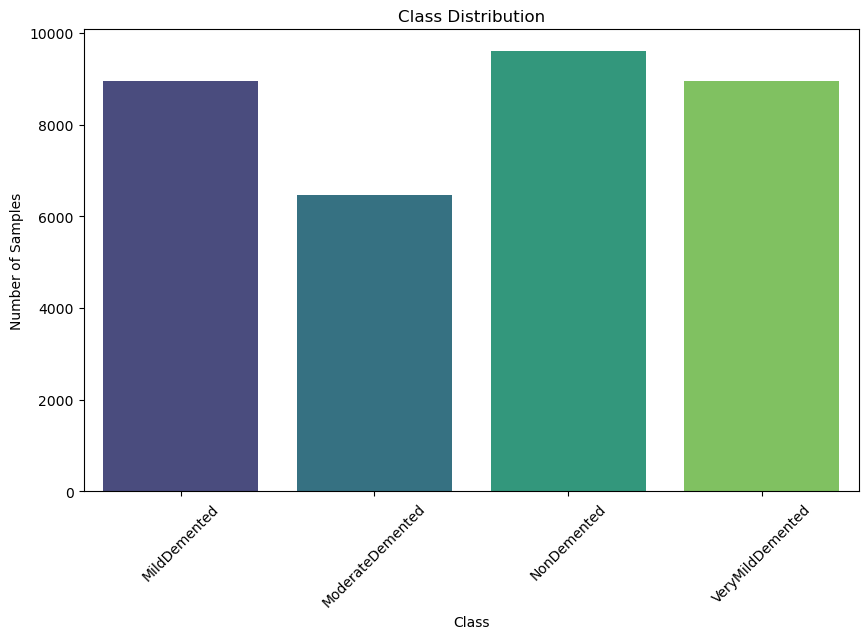

In [19]:
# 1. Basic Dataset Statistics
def dataset_summary(data_dir):
    classes = os.listdir(data_dir)
    print(f"Classes found: {classes}")
    class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
    print("\nNumber of samples per class:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")
    return class_counts

class_counts = dataset_summary(DATA_DIR)

# 2. Visualizing Class Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()




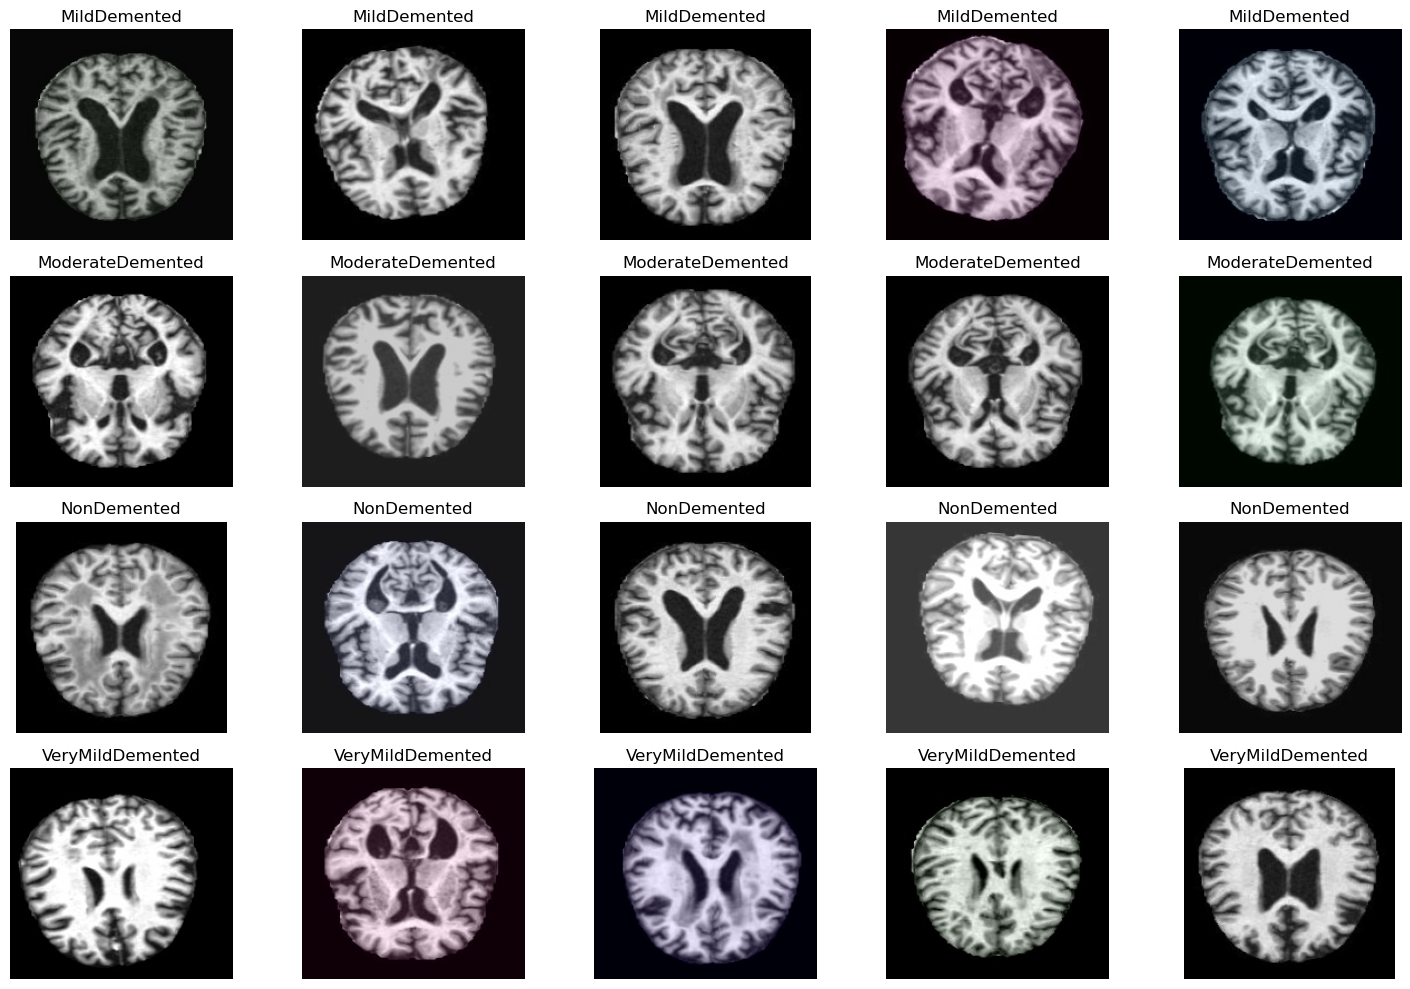

In [10]:
# 3. Display Sample Images
def display_sample_images(data_dir, n_samples=5):
    classes = os.listdir(data_dir)
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = os.listdir(class_dir)[:n_samples]
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path)
            plt.subplot(len(classes), n_samples, i * n_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

display_sample_images(DATA_DIR)

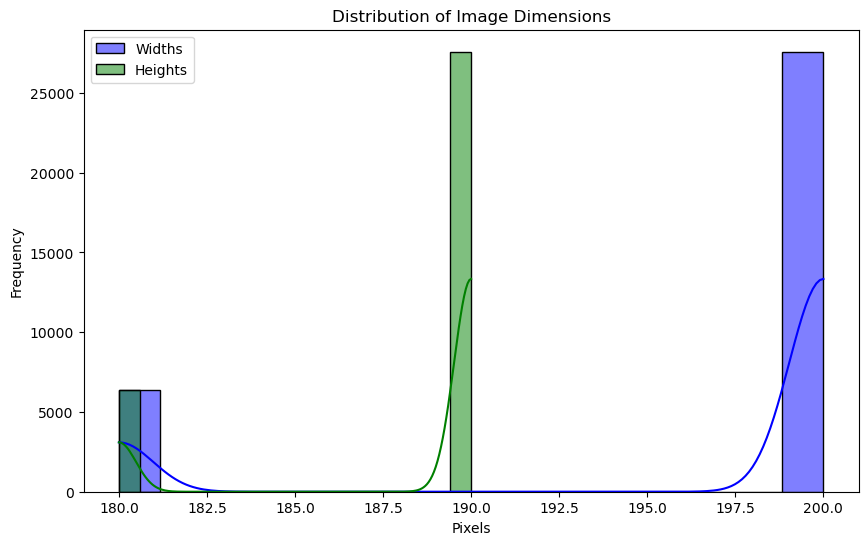

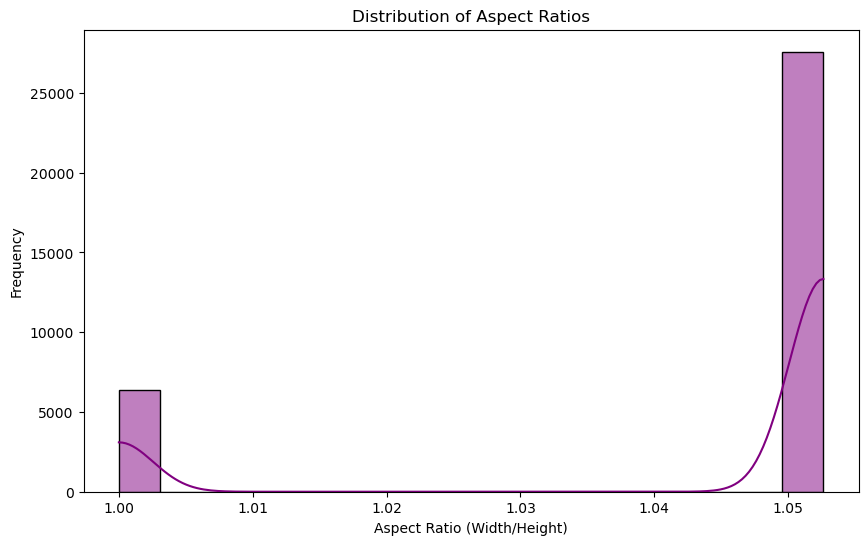

In [11]:
# 4. Image Dimensions and Aspect Ratio Distribution
def analyze_image_dimensions(data_dir):
    widths, heights = [], []
    for cls in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, cls)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path)
            widths.append(img.size[0])
            heights.append(img.size[1])

    plt.figure(figsize=(10, 6))
    sns.histplot(widths, color="blue", label="Widths", kde=True)
    sns.histplot(heights, color="green", label="Heights", kde=True)
    plt.title("Distribution of Image Dimensions")
    plt.xlabel("Pixels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    aspect_ratios = np.array(widths) / np.array(heights)
    plt.figure(figsize=(10, 6))
    sns.histplot(aspect_ratios, color="purple", kde=True)
    plt.title("Distribution of Aspect Ratios")
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Frequency")
    plt.show()

analyze_image_dimensions(DATA_DIR)

In [12]:
# 5. Image Pixel Intensity Distribution
def pixel_intensity_analysis(dataset):
    pixel_values = []
    for images, _ in dataset.take(5):  # Analyze a subset of the dataset
        for img in images:
            pixel_values.extend(img.numpy().ravel())  # Flatten the image to 1D and add pixel values

    pixel_values = np.array(pixel_values)
    plt.figure(figsize=(10, 6))
    sns.histplot(pixel_values, bins=50, kde=True, color="orange")
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.show()

# Training and Testing

In [20]:
# Split validation into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [21]:
# Function to sample datasets with consistent data types
def sample_dataset(dataset, fraction=0.1):
    sampled_images, sampled_labels = [], []
    for x, y in dataset.take(int(tf.data.experimental.cardinality(dataset).numpy() * fraction)):
        sampled_images.append(tf.cast(x, tf.float32))  # Ensure float32 for images
        sampled_labels.append(tf.cast(y, tf.int32))   # Ensure int32 for labels
    sampled_images = tf.concat(sampled_images, axis=0)  # Concatenate all images
    sampled_labels = tf.concat(sampled_labels, axis=0)  # Concatenate all labels
    return tf.data.Dataset.from_tensor_slices((sampled_images, sampled_labels)).batch(BATCH_SIZE)

In [22]:
# Sample datasets for quicker execution
train_dataset = sample_dataset(train_dataset, fraction=0.2)  # Use 50% of data
validation_dataset = sample_dataset(validation_dataset, fraction=0.1)  # Use 20% of data
test_dataset = sample_dataset(test_dataset, fraction=0.2)  # Use 20% of data

# Define CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')  # Multi-class classification
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Train CNN model
cnn_history = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Reduced epochs
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001
        )
    ]
)

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 118s 534ms/step - accuracy: 0.2437 - loss: 10.6537 - val_accuracy: 0.2719 - val_loss: 1.3815 - learning_rate: 0.0010
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.2718 - loss: 1.3802 - val_accuracy: 0.2688 - val_loss: 1.3816 - learning_rate: 0.0010
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 484ms/step - accuracy: 0.2718 - loss: 1.3777 - val_accuracy: 0.2688 - val_loss: 1.3940 - learning_rate: 0.0010
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 140s 473ms/step - accuracy: 0.2718 - loss: 1.3766 - val_accuracy: 0.2688 - val_loss: 1.3967 - learning_rate: 2.0000e-04
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 76s 444ms/step - accuracy: 0.2715 - loss: 1.3769 - val_accuracy: 0.2688 - val_loss: 1.3971 - learning_rate: 2.0000e-04
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 80s 465ms/step - accuracy: 0.2719 - loss: 1.3762 - val_accuracy: 0.2688 - val_loss: 1.3971 - learning_rate: 1.0000e-04
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 77s 452ms/step 

In [24]:
# Define a feature extractor from CNN
feature_extractor = Sequential(cnn_model.layers[:-1])  # Remove final dense layer

In [25]:
# Function to extract features from a dataset
def extract_features_and_reduce(dataset):
    features, labels = [], []
    for x, y in dataset:
        x = tf.cast(x, tf.float32)  # Ensure images are float32
        y = tf.cast(y, tf.int32)   # Ensure labels are int32
        feats = feature_extractor.predict(x)
        features.append(feats)
        labels.append(y.numpy())  # Convert labels to NumPy
    features = np.vstack(features).astype('float32')  # Ensure features are float32
    labels = np.concatenate(labels).astype('int32')  # Ensure labels are int32
    return features, labels

train_features, train_labels = extract_features_and_reduce(train_dataset)
val_features, val_labels = extract_features_and_reduce(validation_dataset)
test_features, test_labels = extract_features_and_reduce(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)
rf_predictions = rf_model.predict(test_features)
print("Random Forest Classification Report")
print(classification_report(test_labels, rf_predictions))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00       124
           2       0.30      1.00      0.46       199
           3       0.00      0.00      0.00       170

    accuracy                           0.30       672
   macro avg       0.07      0.25      0.11       672
weighted avg       0.09      0.30      0.14       672



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_features, train_labels)
svm_predictions = svm_model.predict(test_features)
print("SVM Classification Report")
print(classification_report(test_labels, svm_predictions))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00       124
           2       0.30      1.00      0.46       199
           3       0.00      0.00      0.00       170

    accuracy                           0.30       672
   macro avg       0.07      0.25      0.11       672
weighted avg       0.09      0.30      0.14       672



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(train_features, train_labels)
lr_predictions = lr_model.predict(test_features)
print("Logistic Regression Classification Report")
print(classification_report(test_labels, lr_predictions))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00       124
           2       0.30      1.00      0.46       199
           3       0.00      0.00      0.00       170

    accuracy                           0.30       672
   macro avg       0.07      0.25      0.11       672
weighted avg       0.09      0.30      0.14       672



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Save models for future use
cnn_model.save("cnn_model.h5")
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']

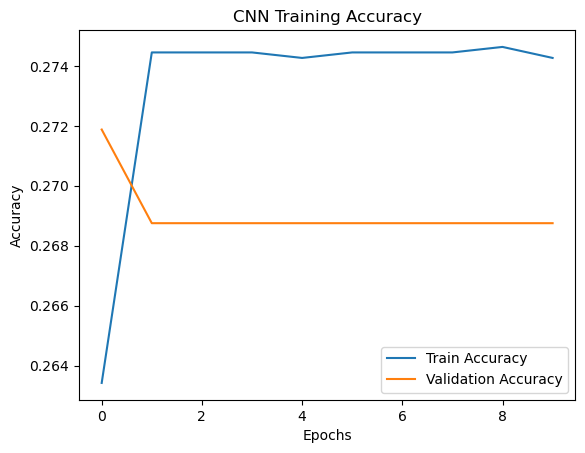

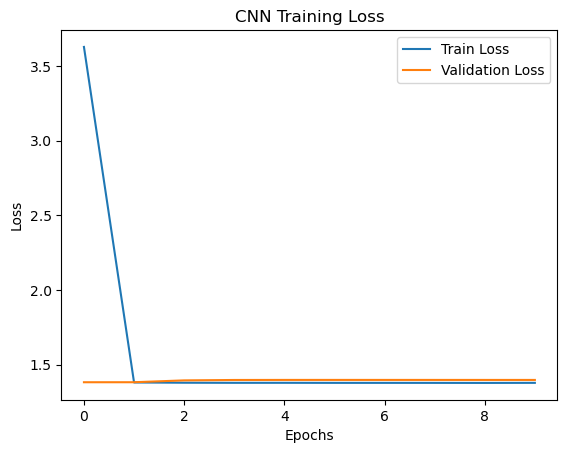

In [30]:
# Visualization of CNN training
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("CNN Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("CNN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

--- Random Forest ---
Accuracy: 0.2961
Precision: 0.0877
Recall: 0.2961
F1 Score: 0.1353


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


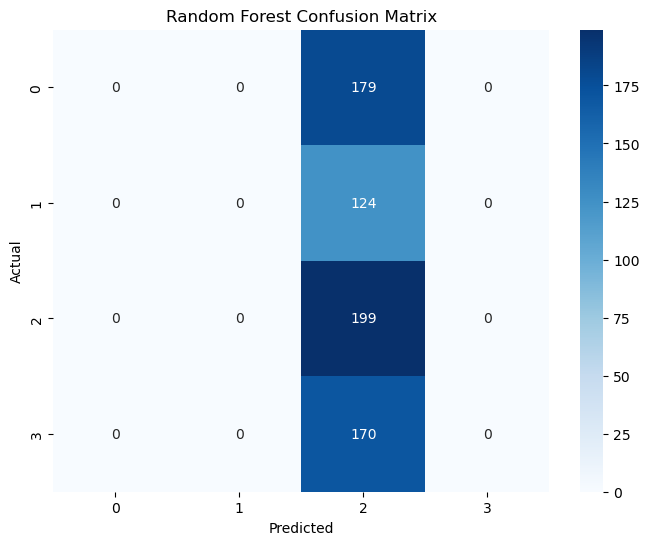

--- Logistic Regression ---
Accuracy: 0.2961
Precision: 0.0877
Recall: 0.2961
F1 Score: 0.1353


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


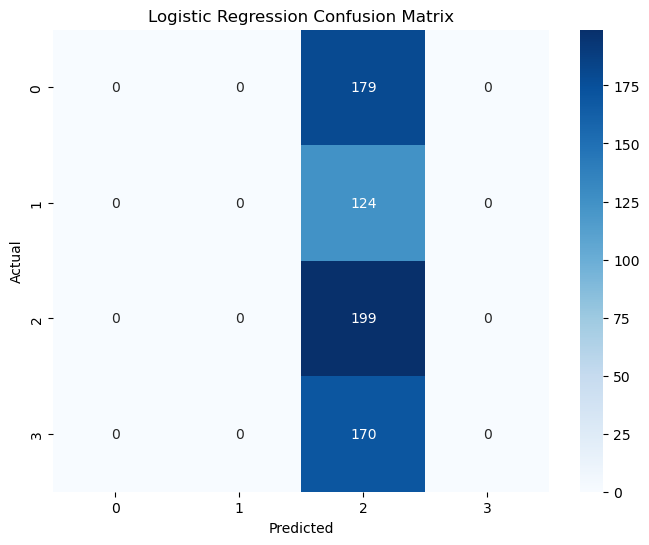

--- Support Vector Machine ---
Accuracy: 0.2961
Precision: 0.0877
Recall: 0.2961
F1 Score: 0.1353


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


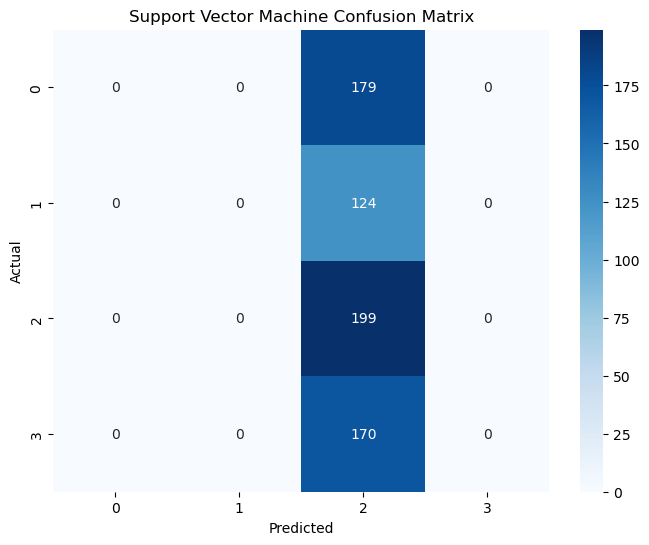

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
--- Convolutional Neural Network ---
Accuracy: 0.2961
Precision: 0.0877
Recall: 0.2961
F1 Score: 0.1353


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


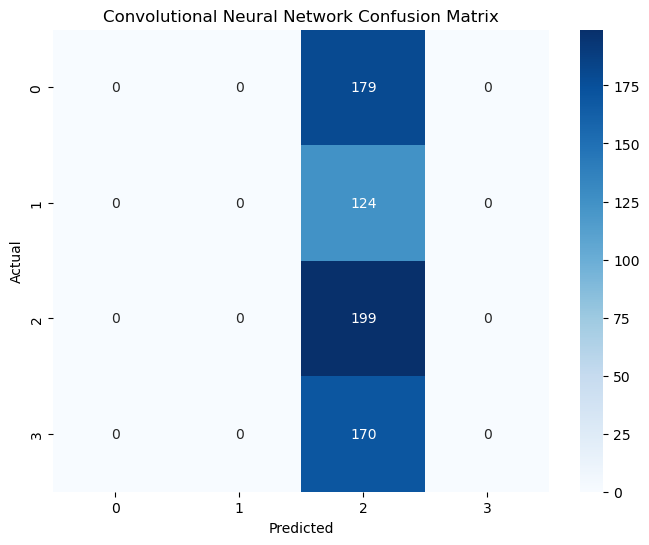

                          Model  Accuracy  Precision    Recall  F1 Score
0                 Random Forest  0.296131   0.087694  0.296131  0.135316
1           Logistic Regression  0.296131   0.087694  0.296131  0.135316
2        Support Vector Machine  0.296131   0.087694  0.296131  0.135316
3  Convolutional Neural Network  0.296131   0.087694  0.296131  0.135316


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate and display metrics
def evaluate_model(predictions, true_labels, model_name):
    print(f"--- {model_name} ---")
    
    # Calculate metrics
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, average='weighted')
    rec = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    # Print metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, prec, rec, f1

# Evaluate Random Forest
rf_predictions = rf_model.predict(test_features)
rf_acc, rf_prec, rf_rec, rf_f1 = evaluate_model(rf_predictions, test_labels, "Random Forest")

# Evaluate Logistic Regression
lr_predictions = lr_model.predict(test_features)
lr_acc, lr_prec, lr_rec, lr_f1 = evaluate_model(lr_predictions, test_labels, "Logistic Regression")

# Evaluate SVM
svm_predictions = svm_model.predict(test_features)
svm_acc, svm_prec, svm_rec, svm_f1 = evaluate_model(svm_predictions, test_labels, "Support Vector Machine")

# Evaluate CNN
cnn_predictions = np.argmax(cnn_model.predict(test_dataset), axis=-1)
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = evaluate_model(cnn_predictions, test_labels, "Convolutional Neural Network")

# Summary of all models
model_metrics = {
    "Model": ["Random Forest", "Logistic Regression", "Support Vector Machine", "Convolutional Neural Network"],
    "Accuracy": [rf_acc, lr_acc, svm_acc, cnn_acc],
    "Precision": [rf_prec, lr_prec, svm_prec, cnn_prec],
    "Recall": [rf_rec, lr_rec, svm_rec, cnn_rec],
    "F1 Score": [rf_f1, lr_f1, svm_f1, cnn_f1]
}

import pandas as pd

metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)
